In [ ]:

#Question: How much neural activity is necessary to predict position? Redundancy?
#          What is the resilience of the system? Dropout layer/neurons -- retrain? How long to retrain? (Add in noise)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from scipy.io import loadmat
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [ ]:
# Load in reach trajectories in xyz (outputs) and reach directions (inputs)

trajectories_and_directions = loadmat('/content/drive/MyDrive/UNC/STOR566/Project/smooth_aligned_position.mat')
out_traj = trajectories_and_directions["realigned_traj"]
in_direc = trajectories_and_directions["all_directions"]

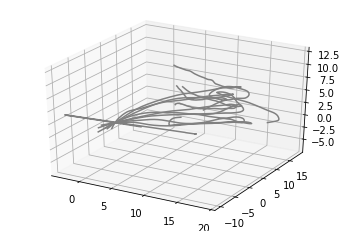

In [ ]:
# Plot some sample reaches
fig = plt.figure()
ax = plt.axes(projection='3d')

for itrial in range(0,10):
  # Data for a three-dimensional line
  x_pos = np.squeeze(out_traj[itrial,0,:])
  y_pos = np.squeeze(out_traj[itrial,1,:])
  z_pos = np.squeeze(out_traj[itrial,2,:])
  ax.plot3D(x_pos, y_pos, z_pos, 'gray')

# plt.axis('off')
plt.rcParams["figure.figsize"] = (20,20)

In [ ]:
N = 151
L = 3

class LSTMPredictor(nn.Module):
  def __init__(self,n_hidden=51):
    super(LSTMPredictor,self).__init__()
    self.n_hidden = n_hidden
    self.lstm1 = nn.LSTMCell(1,self.n_hidden)
    self.lstm2 = nn.LSTMCell(self.n_hidden,self.n_hidden)
    self.linear = nn.Linear(self.n_hidden,1)
  def forward(self,x,future=0):
    outputs = []
    x = x.reshape(-1,1,1)
    x = np.transpose(x, (2,1,0))
    print(x.shape)
    n_samples = x.size(0)
   
    # initial states
    h_t = torch.zeros(n_samples,self.n_hidden,dtype=torch.float32)
    c_t = torch.zeros(n_samples,self.n_hidden,dtype=torch.float32)
    h_t2 = torch.zeros(n_samples,self.n_hidden,dtype=torch.float32)
    c_t2 = torch.zeros(n_samples,self.n_hidden,dtype=torch.float32)
    print('initiation')
    for input_t in x.split(1,dim=0): #split tensor into chunks
      this_input = np.squeeze(input_t)
      this_input = this_input.reshape(-1,1)
      h_t,c_t = self.lstm1(this_input,(h_t,c_t))
      print('line1')
      h_t2,c_t2 = self.lstm2(h_t,(h_t2,c_t2))
      output = self.linear(h_t2)
      outputs.append(output)
    print("loop1")
    for i in range(future):
      h_t,c_t = self.lstm1(output,(h_t,c_t))
      h_t2,c_t2 = self.lstm2(h_t,(h_t2,c_t2))
      output = self.linear(h_t2)
      outputs.append(output)     
    outputs = torch.cat(outputs,dim=1)
    return outputs

In [ ]:
# Initiate classes 
model = LSTMPredictor()
criterion = nn.MSELoss() 
optimizer = optim.LBFGS(model.parameters(),lr=.08)
n_steps = 10

In [ ]:
# Train

for i in range(n_steps):
  print("Step",i)
 
  directions = in_direc[0,:]
  directions = torch.from_numpy(directions).float()
 
  trajectories = out_traj[:,:,:]

  #empty gradient, forward step, backward step
  optimizer.zero_grad()
  out = model(directions)
  loss = criterion(out,trajectories)
  print("loss",loss.item())
  loss.backward()
  optimizer.step(closure)

  with torch.no_grad():
    future = 151
    pred = model(directions, future = future)
    loss = critertion(pred[:,:-future],directions)
    print("Test loss",loss.item())
    y = pred.detach().numpy()
  # Plot
  plt.figure(figsize=(12,6))
  plt.title(f"Step {i+1}")
  n = train_input.shape[1]
  def draw(y_i,color):
    plt.plot(np.arange(n),y_i[:n],color,linewidth=2)
    plt.plot(np.arange(n,n+future),color + ":",linewidth=2)
  draw(y[0],'r')
  draw(y[1],'b')
  draw(y[2],'g')

Step 0
torch.Size([1, 1, 497])
initiation


RuntimeError: ignored